# Periodic Repetition of Lockdowns and its Effects in the SIR Modell

In [1]:
from numba import njit
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
from scipy.integrate import odeint
from scipy.integrate import solve_ivp # Besserer Integrator

In [22]:

R0_in = 0.7
R0_out = 1.5
beta = 0.12
l = 200
mindt = 1.

period = np.linspace(10, 100, l, endpoint =True)

partIn = np.linspace(0, 1, l, endpoint =True)

maxDaysOut = np.outer(period,(1-partIn))
maxDaysIn = np.outer(period,(partIn))

extend=(partIn[0], partIn[-1], period[-1], period[0])

daysIn = np.ones((l,l))*-1
daysOut = np.ones((l,l)) * mindt
oldTime = 0


In [23]:


#@njit(parallel=True)
def lockdown(dt,shape=(l,l)):
    global daysIn, daysOut
    daysIn_new = np.ones(daysIn.shape) *-1
    daysOut_new = np.ones(daysOut.shape) *-1
    daysIn_new[np.logical_and(daysIn >= 0, daysIn <= maxDaysIn)] = daysIn[np.logical_and(daysIn >= 0, daysIn <= maxDaysIn)] + dt
    daysOut_new[daysIn > maxDaysIn] = 0
    daysIn_new[daysIn > maxDaysIn] = -1
    
    
    
    daysOut_new[np.logical_or(daysIn < 0, daysIn > maxDaysIn)] = daysOut[np.logical_or(daysIn < 0, daysIn > maxDaysIn)]+dt
    daysIn_new[daysOut>=maxDaysOut] = dt
    daysOut_new[daysOut>=maxDaysOut] = -1
    
    daysOut = daysOut_new
    daysIn = daysIn_new
    
    ret = np.ones(shape)
    ret[daysIn>=0] *= R0_in * beta
    ret[daysIn<0] *= R0_out * beta
    return ret

In [61]:
def newLockdown(t, shape=(l, l)):
    days_inperiod = np.mod(int(t), period)
    plt.plot(days_inperiod)
    days_in = np.outer(days_inperiod ,(1-partIn))
    isLockdown = (days_in > 0)
    ret = np.ones(shape)
    ret[isLockdown] = R0_in * beta
    ret[np.logical_not(isLockdown)] = R0_out*beta
    return ret

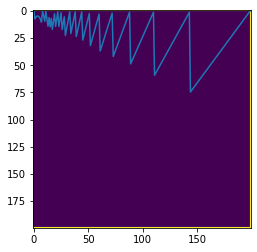

In [62]:
plt.imshow(newLockdown(300))

The Lockdown function is working corrctly. Now Implement the odes so that it works for matrizes with a constant influx $H$ from the outside
For this I use a basic SIR-modell
$$\dot x = - alpha *x*y - H$$
$$\dot z = beta *y$$
$$\dot y = -(dx+dz)$$

In [24]:

def odes(t, p, lockdown, influx):
    global oldTime
    x = p[:l*l]
    y = p[l*l:2*l*l]
    z = p[2*l*l:]
    
    dt = t-oldTime
    oldTime = t
    
    alpha = lockdown(dt).flatten()
    
    dx = - alpha *x*y - influx*dt
    dz = beta *y
    dy = -(dx+dz)
    
    return np.concatenate([dx,dy,dz])

Set the lockdown Paramters

Choose the Starting Par

In [25]:


N = 8.2 * 10**7
infected = 2* 10**5/N
removed = 2.1*10**6/N
influx = 20000/N
notInfected = 1 - infected - removed

matrix = np.ones((l,l))
p0 = np.array([notInfected*matrix, infected*matrix, removed *matrix]).flatten()


oldTime = 0
R0_in = 0.7
R0_out = 1.5
beta = 0.12
l = 200
mindt = 1.

period = np.linspace(10, 100, l, endpoint =True)

partIn = np.linspace(0, 1, l, endpoint =True)

maxDaysOut = np.outer(period,(1-partIn))
maxDaysIn = np.outer(period,(partIn))

extend=(partIn[0], partIn[-1], period[-1], period[0])

daysIn = np.ones((l,l))*-1
daysOut = np.ones((l,l)) * mindt

In [26]:
mindt = 1
sol = solve_ivp(odes, (0,900), p0, max_step=mindt, args=(lockdown, influx))
p=sol.y
t = sol.t
x = p[:l*l, :]
y = p[l*l:2*l*l, :]
z = p[2*l*l:, :]

In [27]:
x = x.reshape(l,l,len(t))
y = y.reshape(l,l,len(t))
z = z.reshape(l,l,len(t))

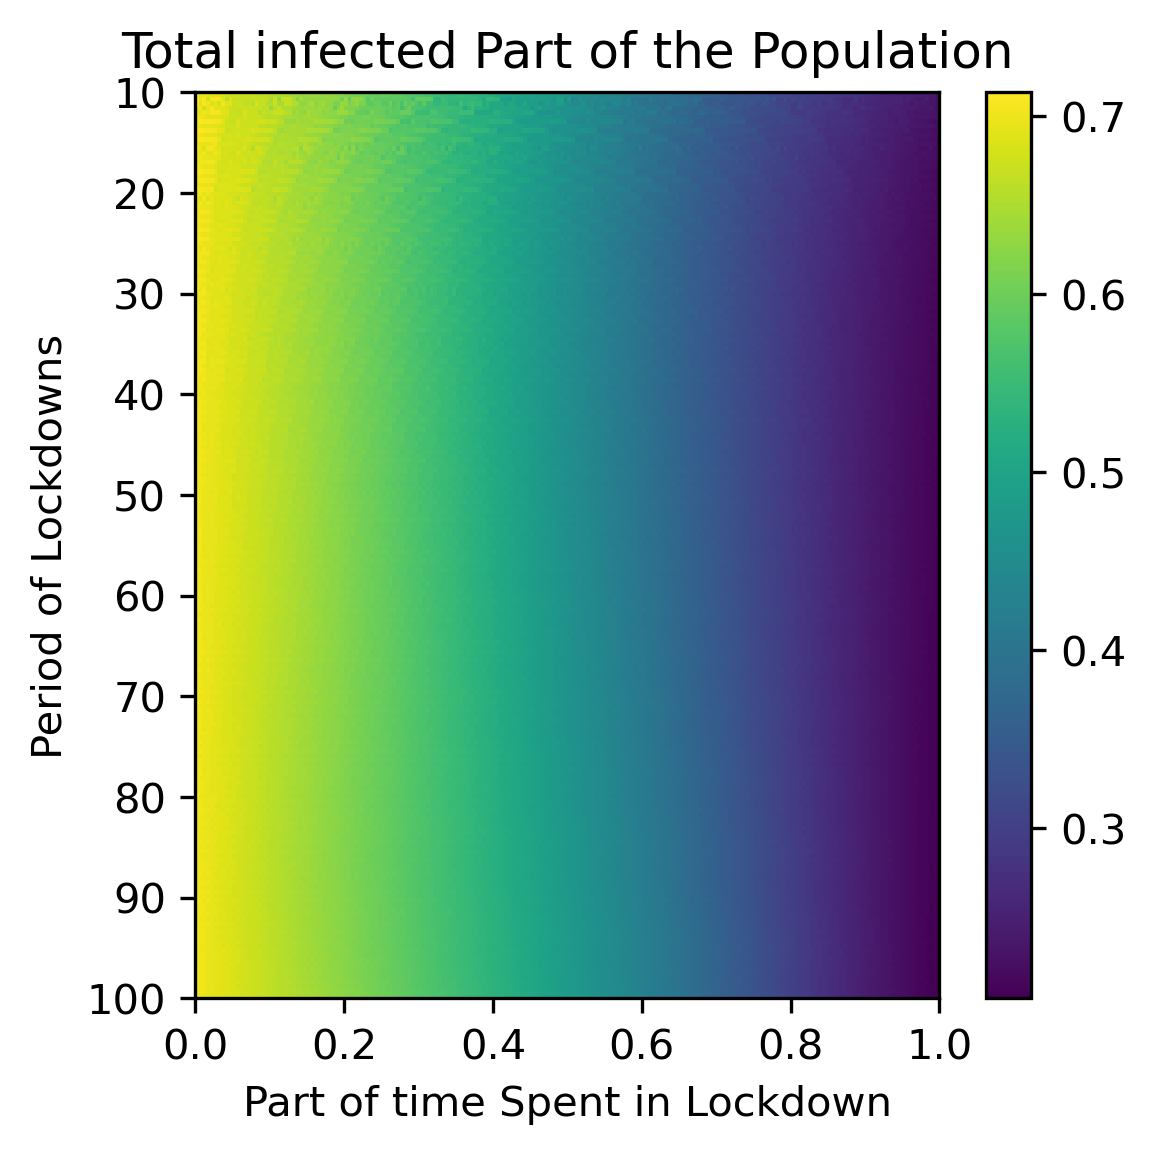

In [28]:
total_infected = (1-x)[:,:,-1]
plt.figure(2, (4,4), 300)
plt.imshow(total_infected, extent=extend, aspect='auto')
plt.xlabel("Part of time Spent in Lockdown")
plt.ylabel("Period of Lockdowns")
plt.title("Total infected Part of the Population")
plt.colorbar()

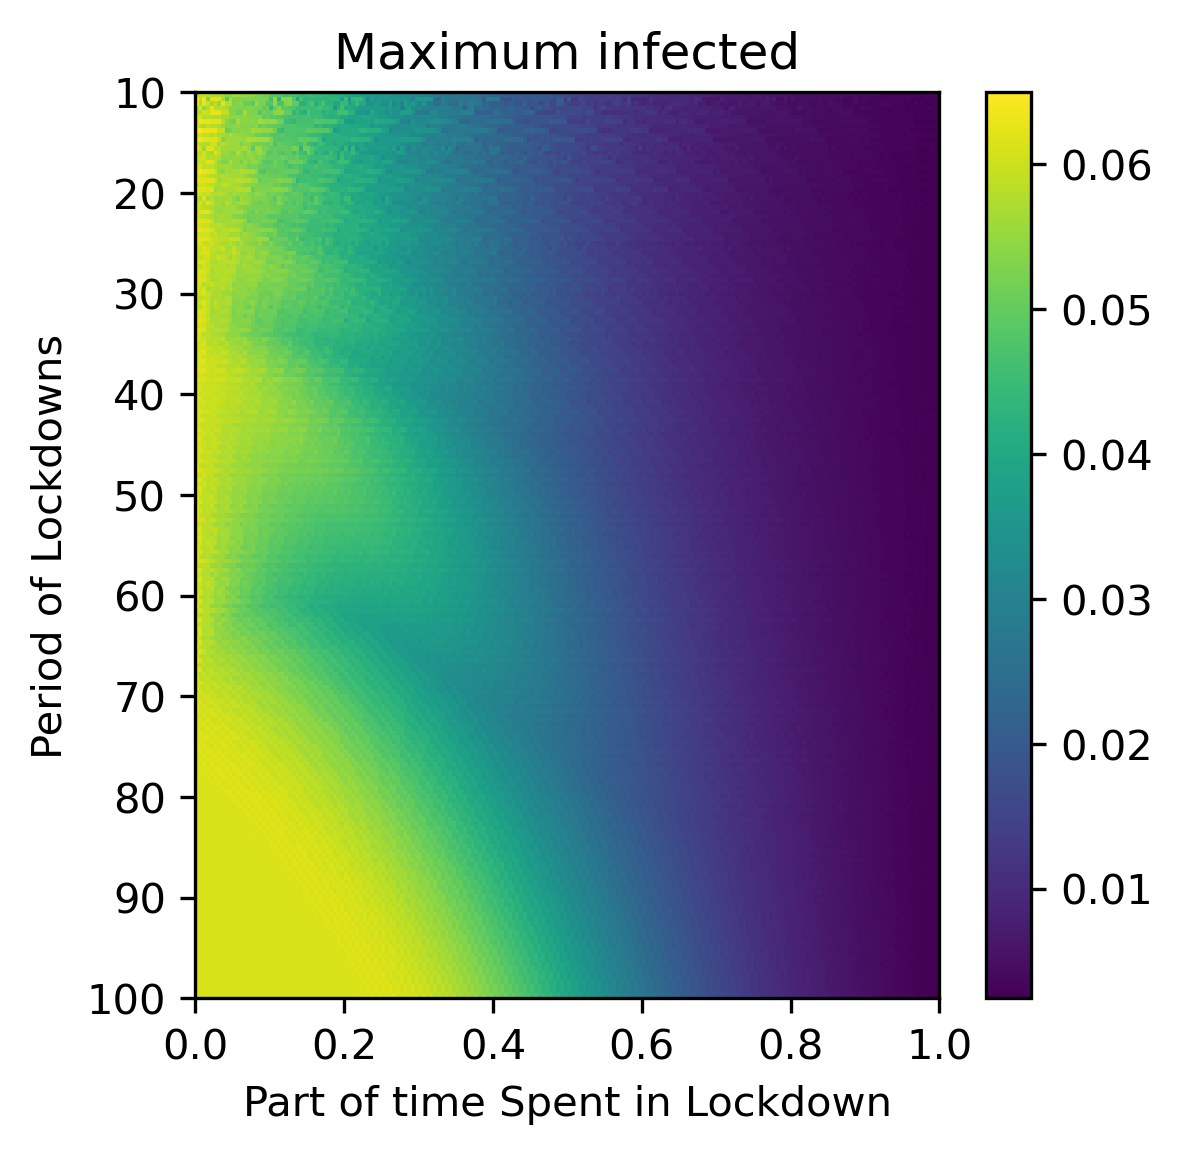

In [29]:
max_infected = np.amax(y, 2)
plt.figure(1, (4,4), 300)
plt.imshow(max_infected, extent=extend, aspect='auto')
plt.xlabel("Part of time Spent in Lockdown")
plt.ylabel("Period of Lockdowns")
plt.title("Maximum infected")
plt.colorbar()

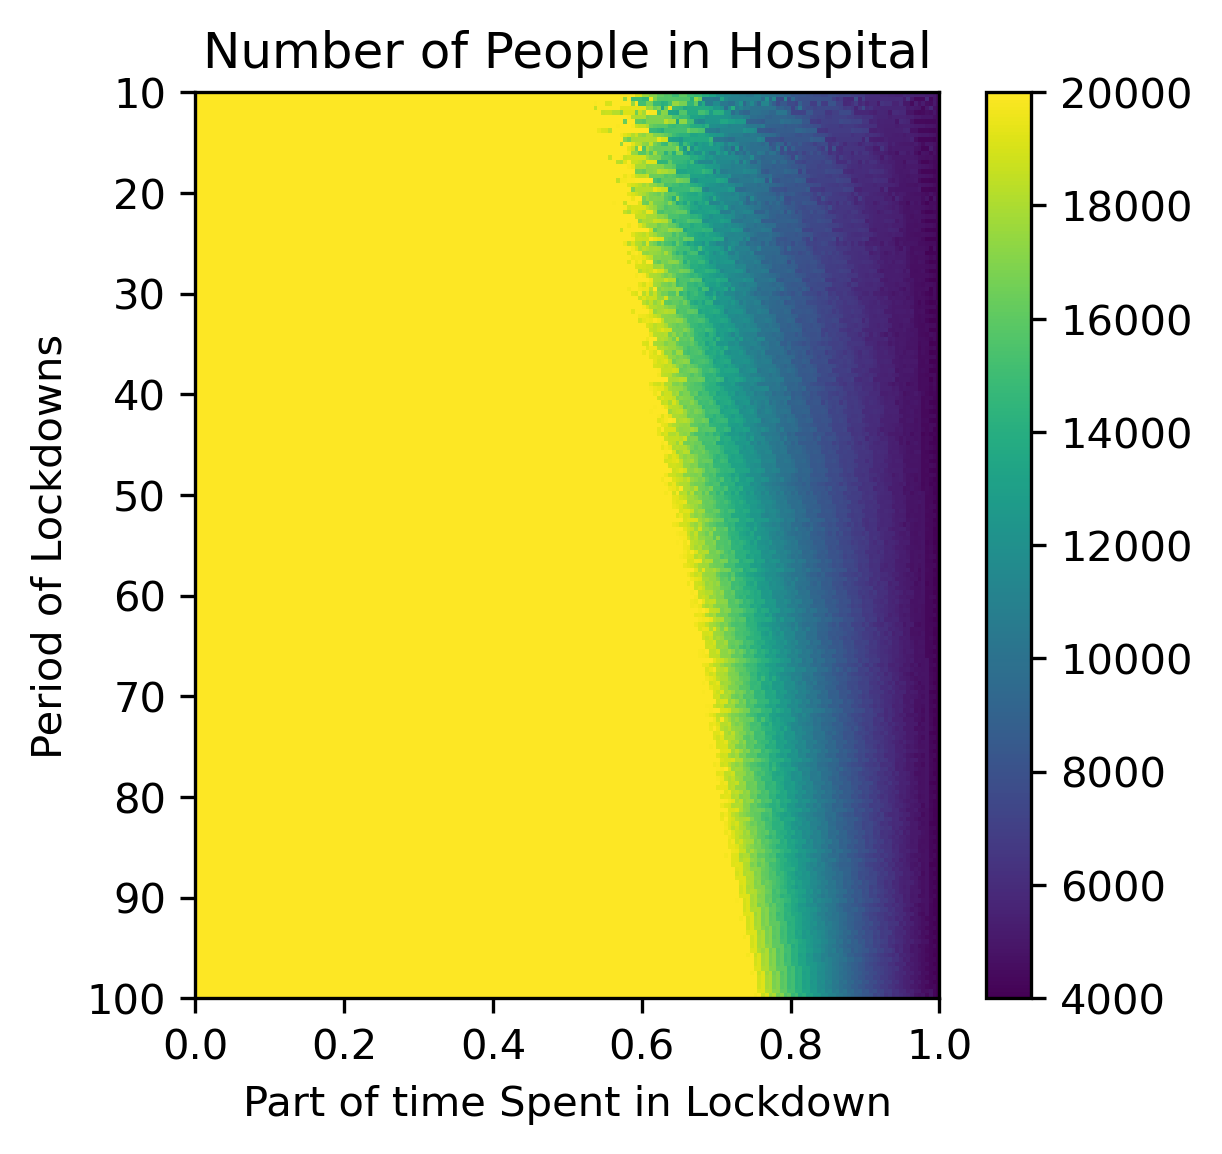

In [30]:
max_infected = np.amax(y, 2)*0.02*N
plt.figure(3, (4,4), 300)
plt.imshow(max_infected, extent=extend, aspect='auto', vmax=20000)
plt.xlabel("Part of time Spent in Lockdown")
plt.ylabel("Period of Lockdowns")
plt.title("Number of People in Hospital")
plt.colorbar()